# Introduction

In this notebook we try to classify images with a MLP. Does this work?

We try this, since MLPs are normally not used for image classification. Why?

Let's learn more about the reason why MLPs are not used for image classification by trying it out!

# Check dependencies

In [1]:
import matplotlib
print(matplotlib.__version__)

import numpy as np
print(np.__version__)

import cv2
print(cv2.__version__)

import pickle
print(pickle.format_version)

import tensorflow
print(tensorflow.__version__)

3.3.2
1.19.2
4.5.1
4.0
2.3.0


# Load in the image dataset generated before

In [2]:
fname = "../01_cnn_generating_image_data/persons_icons_dataset.pkl"

fobj = open(fname, "rb")
dataset = pickle.load(fobj)
fobj.close()

In [3]:
type(dataset)

list

In [4]:
len(dataset)

2

In [5]:
list_imgs, list_labels = dataset

In [6]:
len(list_imgs)

500

In [7]:
len(list_labels)

500

In [8]:
list_imgs[:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [9]:
list_labels[:2]

[2, 2]

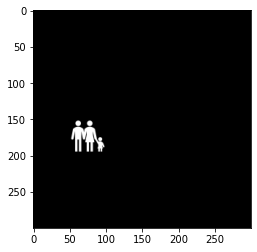

In [10]:
import matplotlib.pyplot as plt

plt.imshow(list_imgs[0], cmap="gray")
plt.show()

In [11]:
label = list_labels[0]
label

2

In [12]:
min(list_labels), max(list_labels)

(0, 4)

In [13]:
nr_object_classes = max(list_labels)+1
nr_object_classes

5

# Prepare input and output matrices

In [14]:
example_img = list_imgs[0]

In [15]:
type(example_img)

numpy.ndarray

In [16]:
example_img.shape

(300, 300)

In [17]:
vec_len = example_img.shape[0] * example_img.shape[1]
vec_len

90000

In [18]:
example_img.size

90000

In [19]:
nr_images = len(list_imgs)
nr_images

500

In [20]:
X = np.zeros((nr_images, vec_len))

In [21]:
X.shape

(500, 90000)

In [22]:
Y = np.zeros((nr_images, nr_object_classes))

In [23]:
def get_one_hot_vec(length, pos):
    vec = np.zeros(length)
    vec[pos] = 1
    return vec

In [24]:
test_vec = get_one_hot_vec(nr_object_classes, 2)
test_vec

array([0., 0., 1., 0., 0.])

In [25]:
for img_nr in range(0, nr_images):
    
    # get the next image
    img = list_imgs[img_nr]
    
    # represent image as one long vector
    input_vec = img.flatten()
    
    # save image as data row in input matrix
    X[img_nr,:] = input_vec
    
    # get label (0,1,2,3,or 4)
    label = list_labels[img_nr]
    
    # save label as one-hot encoded vector    
    Y[img_nr,:] = get_one_hot_vec(nr_object_classes, label)

# Split image data into train and test data

In [26]:
N = len(X)
N

500

In [27]:
half = int(N/2)
half

250

In [28]:
X_train = X[:half]
Y_train = Y[:half]

X_test  = X[half:]
Y_test  = Y[half:]

In [29]:
X_train.shape

(250, 90000)

In [30]:
X_test.shape

(250, 90000)

In [31]:
len(Y_train)

250

In [32]:
len(Y_test)

250

# Build the MLP model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

K.clear_session()

nr_hidden_neurons_layer1 = 50
nr_hidden_neurons_layer2 = 25
nr_output_neurons = nr_object_classes

model = Sequential()
model.add(Dense(nr_hidden_neurons_layer1, activation="relu", name="hidden_layer_1", input_dim=vec_len))
model.add(Dense(nr_hidden_neurons_layer2, activation="relu", name="hidden_layer_2"))
model.add(Dense(nr_output_neurons, activation="linear", name="output_layer"))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 50)                4500050   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 25)                1275      
_________________________________________________________________
output_layer (Dense)         (None, 5)                 130       
Total params: 4,501,455
Trainable params: 4,501,455
Non-trainable params: 0
_________________________________________________________________


# Test the model before training

In [49]:
def test_model(model, X_test, Y_test, show_some_predictions=False):
    preds = model.predict(X_test)
    
    nr_test_samples = Y_test.shape[0]
    correct = 0
    for test_nr in range(0,nr_test_samples):        
        should_label = np.argmax(Y_test[test_nr])
        is_label     = np.argmax(preds[test_nr])
        
        if should_label==is_label:
            correct += 1
        
        if show_some_predictions and test_nr<10:
            print("Should: {0} vs. Is: {1}".format(Y_test[test_nr], preds[test_nr]))
            print("Should label: {0} vs. Is label: {1}\n".format(should_label, is_label))            
            
    correctly_classified_percent = (correct / nr_test_samples) * 100.0
    print("Correctly classified: {0:.2f}".format(correctly_classified_percent))

In [50]:
test_model(model, X_test, Y_test, show_some_predictions=True)

Should: [0. 0. 0. 1. 0.] vs. Is: [ 0.08539777 -0.04383679  0.1300529   0.02824651 -0.09275603]
Should label: 3 vs. Is label: 2

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.01056091 -0.0902172   0.17940634  0.05802331 -0.03595814]
Should label: 2 vs. Is label: 2

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.02934222 -0.08629819  0.1517542   0.02823925  0.01129801]
Should label: 3 vs. Is label: 2

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.08075342 -0.05763577  0.18586943  0.0689133  -0.07246027]
Should label: 4 vs. Is label: 2

Should: [0. 1. 0. 0. 0.] vs. Is: [ 0.02490337 -0.10026268  0.10215046  0.08572008 -0.06079626]
Should label: 1 vs. Is label: 2

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.0725394  -0.0248275   0.06198974  0.0174985  -0.04376858]
Should label: 0 vs. Is label: 0

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.11192266  0.02887678  0.19548482  0.147779   -0.11836965]
Should label: 2 vs. Is label: 2

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.00813738 -0.02248607  0.06266528 -0.05525431 -0.03515659]
Should la

In [51]:
test_model(model, X_train, Y_train, show_some_predictions=True)

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.08458976  0.00974172  0.06373041 -0.08594471 -0.0561556 ]
Should label: 2 vs. Is label: 2

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.00321781 -0.07662577  0.07128339  0.0333743  -0.01544544]
Should label: 2 vs. Is label: 2

Should: [0. 0. 0. 0. 1.] vs. Is: [-0.01452462 -0.0795062   0.03752126 -0.00867483 -0.01098401]
Should label: 4 vs. Is label: 2

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.04183546 -0.0972762   0.08376031  0.0105455  -0.05911036]
Should label: 0 vs. Is label: 2

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.06345933 -0.0481087   0.02768949  0.05652401 -0.05940202]
Should label: 0 vs. Is label: 0

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.00430148 -0.04363136  0.06672464  0.04500688 -0.12349624]
Should label: 0 vs. Is label: 2

Should: [0. 0. 0. 0. 1.] vs. Is: [-0.0102099  -0.0361618   0.15399343  0.02574774 -0.05578332]
Should label: 4 vs. Is label: 2

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.05802858 -0.08158381 -0.06416079  0.04878206 -0.10715464]
Should la

# Train the MLP

In [52]:
history = model.fit(X_train,Y_train, epochs=100, verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2037
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1865
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1739
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1641
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1562
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1493
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1434
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1379
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1329
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1282
Epoch 11/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1240
Epoch 12/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1200
Epoch 13/100
8/8 [==============================]

In [53]:
type(history)

tensorflow.python.keras.callbacks.History

In [54]:
type(history.history)

dict

In [55]:
history.history

{'loss': [0.20366676151752472,
  0.18651552498340607,
  0.17386996746063232,
  0.1640997678041458,
  0.1562006026506424,
  0.14933766424655914,
  0.14336518943309784,
  0.1378789246082306,
  0.1328665316104889,
  0.12820352613925934,
  0.12397480010986328,
  0.11997602880001068,
  0.1163172572851181,
  0.11281067132949829,
  0.10963469743728638,
  0.10671842843294144,
  0.10390245914459229,
  0.10126931220293045,
  0.09881199151277542,
  0.09647587686777115,
  0.09426818042993546,
  0.09211575984954834,
  0.0901583582162857,
  0.08818298578262329,
  0.08629667013883591,
  0.08447571843862534,
  0.08276459574699402,
  0.08106168359518051,
  0.07943519949913025,
  0.07785963267087936,
  0.07635485380887985,
  0.07490912079811096,
  0.07349727302789688,
  0.07216667383909225,
  0.07085926085710526,
  0.06960220634937286,
  0.06837451457977295,
  0.06720054149627686,
  0.06607117503881454,
  0.0649651363492012,
  0.06387018412351608,
  0.0627942830324173,
  0.06177201122045517,
  0.0607452

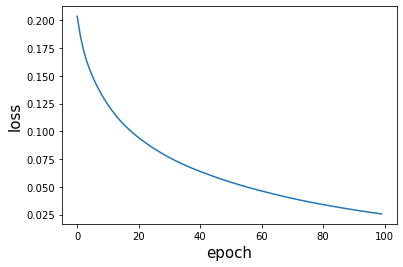

In [56]:
plt.plot(history.history["loss"])
plt.xlabel("epoch", fontsize=15)
plt.ylabel("loss", fontsize=15)
plt.show()

# Test the model after training

In [57]:
test_model(model, X_train, Y_train)

Correctly classified: 99.60


In [58]:
test_model(model, X_test, Y_test)

Correctly classified: 20.80


# Conclusions for the MLP

The test of this MLP for image classification shows.

It performs perfectly on the **training data**, since it used it huge sets of parameters to directly map the few input images to the desired output values.

However, on new images / **test data** (just translated variants of the original image), the MLP is not besser than randomly guessing the class of the image.

By this we show that image classification with a MLP is not a good idea. Instead, we need another model that is able to come up with a representation of the image that is (mostly) invariant to translations (and all the other transformations, e.g. rotation).

This will lead us to Convolutional Neural Networks (CNN).